# Linear Regression

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from six.moves import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
np.random.seed(56101)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

Linear regression is ubiquitous in research. In this example we'll fit a line 

$$ y=mx+b $$ 

to data where the error bars have been underestimated and need to be inflated by a factor $f$. This example is taken from the [emcee documentation](http://dan.iel.fm/emcee/current/user/line/).

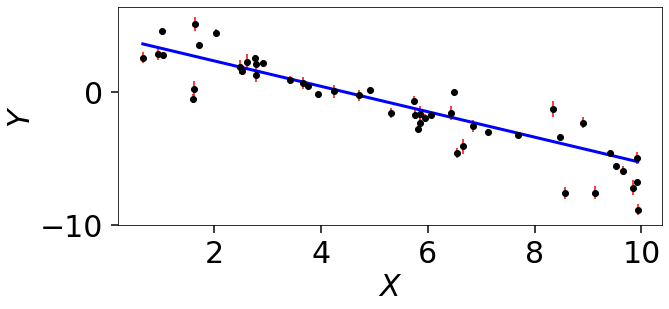

In [4]:
# truth
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# generate mock data
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y_true = m_true * x + b_true
y = y_true + np.abs(f_true * y_true) * np.random.randn(N)
y += yerr * np.random.randn(N)

# plot results
plt.figure(figsize=(10, 5))
plt.errorbar(x, y, yerr=yerr, fmt='ko', ecolor='red')
plt.plot(x, y_true, color='blue', lw=3)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.tight_layout()

We will assume the errors are Normal and impose uniform priors on $(m, b, \ln f)$.

In [5]:
# log-likelihood
def loglike(theta):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2 * lnf))
    
    return -0.5 * (np.sum((y-model)**2 * inv_sigma2 - np.log(inv_sigma2)))

# prior transform
def prior_transform(utheta):
    um, ub, ulf = utheta
    m = 5.5 * um - 5.
    b = 10. * ub
    lnf = 11. * ulf - 10.
    
    return m, b, lnf

Let's sample from this distribution using multiple bounding ellipsoids and random walk

In [7]:
dsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=3,
                                        bound='multi', sample='rwalk')
dsampler.run_nested()
dres = dsampler.results

16114it [07:30, 35.80it/s, batch: 7 | bound: 23 | nc: 23 | ncall: 337131 | eff(%):  4.780 | loglstar: -39.399 < -33.945 < -34.496 | logz: -44.480 +/-  0.085 | stop:  0.929]            


Let's see how we did.

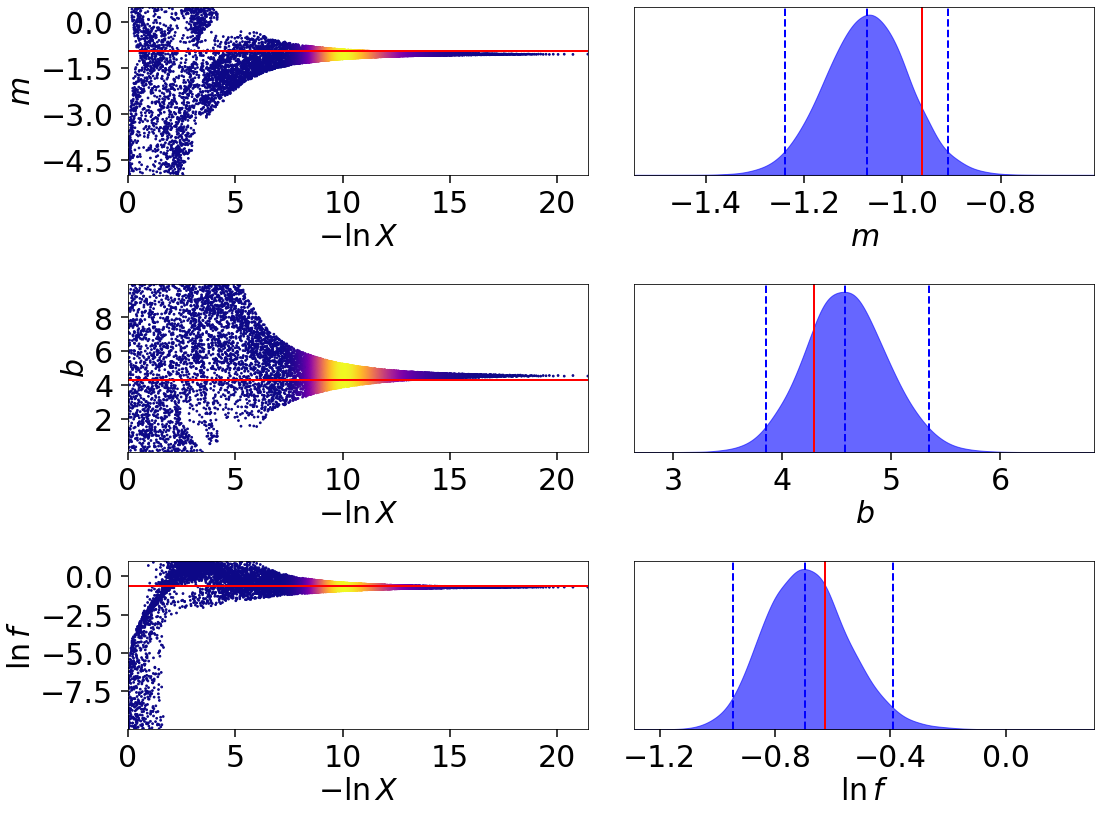

In [8]:
from dynesty import plotting as dyplot

truths = [m_true, b_true, np.log(f_true)]
labels = [r'$m$', r'$b$', r'$\ln f$']
fig, axes = dyplot.traceplot(dsampler.results, truths=truths, labels=labels,
                             fig=plt.subplots(3, 2, figsize=(16, 12)))
fig.tight_layout()

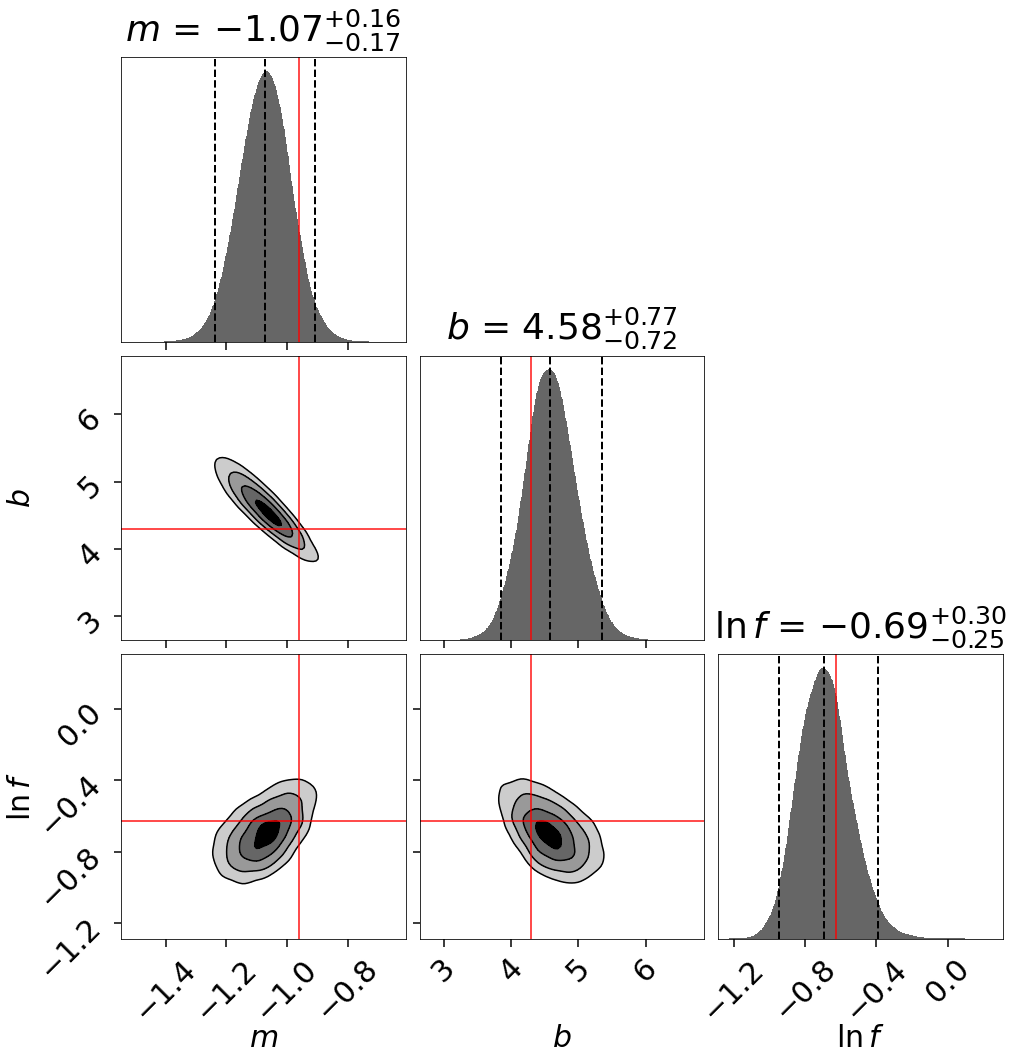

In [9]:
fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(3, 3, figsize=(15, 15)))